# Graficos de campos de viento/temperatura

In [1]:
from siphon.catalog import TDSCatalog

In [2]:
# si el catalogo que se desea es de 0.25 grados
best_gfs = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/NCEP/GFS/Global_0p25deg/catalog.xml')

# lista de colecciones
print(best_gfs.datasets)

['Full Collection (Reference / Forecast Time) Dataset', 'Best GFS Quarter Degree Forecast Time Series', 'Latest Collection for GFS Quarter Degree Forecast']


In [3]:
best_ds = list(best_gfs.datasets.values())[1]

# diccionario de urls disponibles con la información
best_ds.access_urls

{'OPENDAP': 'https://thredds.ucar.edu/thredds/dodsC/grib/NCEP/GFS/Global_0p25deg/Best',
 'CdmRemote': 'https://thredds.ucar.edu/thredds/cdmremote/grib/NCEP/GFS/Global_0p25deg/Best',
 'JupyterNotebook': 'https://thredds.ucar.edu/thredds/notebook/grib/NCEP/GFS/Global_0p25deg/Best',
 'NetcdfSubset': 'https://thredds.ucar.edu/thredds/ncss/grid/grib/NCEP/GFS/Global_0p25deg/Best',
 'WMS': 'https://thredds.ucar.edu/thredds/wms/grib/NCEP/GFS/Global_0p25deg/Best',
 'WCS': 'https://thredds.ucar.edu/thredds/wcs/grib/NCEP/GFS/Global_0p25deg/Best',
 'ISO': 'https://thredds.ucar.edu/thredds/iso/grib/NCEP/GFS/Global_0p25deg/Best',
 'NCML': 'https://thredds.ucar.edu/thredds/ncml/grib/NCEP/GFS/Global_0p25deg/Best',
 'UDDC': 'https://thredds.ucar.edu/thredds/uddc/grib/NCEP/GFS/Global_0p25deg/Best'}

In [4]:
best_ds = best_gfs.datasets[0]
ncss =best_ds.subset()
query = ncss.query()

Requerimiento de datos, para eso recurrimos a la función `query.lonlat_box()`, recuerda que en este caso no se trabaja con `time_range`

In [5]:
from datetime import datetime, timedelta, timezone

now = datetime.now(timezone.utc)

# buscando la posición de lima
query.lonlat_box(west=270, north=0, east=300, south=-20).vertical_level(100_000).time(now)
query.accept('netcdf4')
query.variables('Temperature_isobaric', 
                'Relative_humidity_isobaric', 
                'u-component_of_wind_isobaric', 
                'v-component_of_wind_isobaric')

# haciendo el requerimiento de los datos
data = ncss.get_data(query)

Para dejar mas facil el trabajo con nuestro archivo utilicemos el `xarray`

In [6]:
from xarray.backends import NetCDF4DataStore
import xarray as xr

data_2 = xr.open_dataset(NetCDF4DataStore(data))
data_2

<xarray.Dataset>
Dimensions:                        (reftime: 1, time: 1, latitude: 81,
                                    isobaric: 1, longitude: 121)
Coordinates:
  * reftime                        (reftime) datetime64[ns] 2022-10-26T12:00:00
    timeForecast                   (time) datetime64[ns] ...
  * latitude                       (latitude) float32 0.0 -0.25 ... -19.75 -20.0
  * time                           (time) datetime64[ns] 2022-10-26T21:00:00
  * isobaric                       (isobaric) float64 1e+05
  * longitude                      (longitude) float32 270.0 270.2 ... 300.0
Data variables:
    Temperature_isobaric           (reftime, time, isobaric, latitude, longitude) float32 ...
    Relative_humidity_isobaric     (reftime, time, isobaric, latitude, longitude) float32 ...
    u-component_of_wind_isobaric   (reftime, time, isobaric, latitude, longitude) float32 ...
    v-component_of_wind_isobaric   (reftime, time, isobaric, latitude, longitude) float32 ...
    LatLon_721X1440-0p13S-180p00E  int32 ...
Attributes: (12/13)
    Originating_or_generating_Center:                                        ...
    Originating_or_generating_Subcenter:                                     ...
    GRIB_table_version:                                                      ...
    Type_of_generating_process:                                              ...
    Analysis_or_forecast_generating_process_identifier_defined_by_originating...
    Conventions:                                                             ...
    ...                                                                                ...
    featureType:                                                             ...
    History:                                                                 ...
    geospatial_lat_min:                                                      ...
    geospatial_lat_max:                                                      ...
    geospatial_lon_min:                                                      ...
    geospatial_lon_max:                                                      ...

## Trabajando con `geocat-viz`

In [7]:
import xarray as xr
import numpy as np

from matplotlib import pyplot as plt

from cartopy import feature as cf
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader as ShapeReader, natural_earth

import geocat.datafiles as gdf
import cmaps
import geocat.viz as gv

In [8]:
data_2.Temperature_isobaric.shape

(1, 1, 1, 81, 121)

In [9]:
# vamos a trabajar la longitud con -180, el modelo retorno de 0 a 360
lon = data_2.longitude.data - 360
lat = data_2.latitude.data
T = data_2.Temperature_isobaric.data[0,0,0] - 273.15
U = data_2['u-component_of_wind_isobaric'].data[0,0,0]
V = data_2['v-component_of_wind_isobaric'].data[0,0,0]

# generando los puntos para graficar
lon, lat = np.meshgrid(lon, lat)

In [10]:
T.shape

(81, 121)

In [11]:
data_2['u-component_of_wind_isobaric']

<xarray.DataArray 'u-component_of_wind_isobaric' (reftime: 1, time: 1,
                                                  isobaric: 1, latitude: 81,
                                                  longitude: 121)>
array([[[[[-0.870619, ..., -0.070619],
          ...,
          [-7.900619, ..., -1.370619]]]]], dtype=float32)
Coordinates:
  * reftime       (reftime) datetime64[ns] 2022-10-26T12:00:00
    timeForecast  (time) datetime64[ns] 2022-10-26T21:00:00
  * latitude      (latitude) float32 0.0 -0.25 -0.5 -0.75 ... -19.5 -19.75 -20.0
  * time          (time) datetime64[ns] 2022-10-26T21:00:00
  * isobaric      (isobaric) float64 1e+05
  * longitude     (longitude) float32 270.0 270.2 270.5 ... 299.5 299.8 300.0
Attributes:
    long_name:                       u-component of wind @ Isobaric surface
    units:                           m/s
    Grib_Variable_Id:                VAR_7-0--1-2_L100
    Grib2_Parameter:                 [0 2 2]
    Grib2_Parameter_Discipline:      Meteorological products
    Grib2_Parameter_Category:        Momentum
    Grib2_Parameter_Name:            u-component of wind
    Grib2_Level_Type:                100
    Grib2_Level_Desc:                Isobaric surface
    Grib2_Generating_Process_Type:   Forecast
    Grib2_Statistical_Process_Type:  UnknownStatType--1
    grid_mapping:                    LatLon_721X1440-0p13S-180p00E

In [12]:
U

array([[-0.8706189 ,  0.5793811 ,  1.2793812 , ..., -1.0706189 ,
        -0.2906189 , -0.0706189 ],
       [-2.290619  ,  0.92938113,  2.6893811 , ..., -0.9106189 ,
        -0.2806189 ,  0.0693811 ],
       [-0.57061887,  1.8693811 ,  4.629381  , ..., -0.82061887,
        -0.2506189 , -0.0706189 ],
       ...,
       [-7.870619  , -7.710619  , -7.790619  , ...,  0.3293811 ,
        -0.8806189 , -1.3806189 ],
       [-7.730619  , -7.770619  , -7.7606187 , ...,  0.5193811 ,
        -0.82061887, -1.230619  ],
       [-7.900619  , -7.910619  , -7.7806187 , ...,  0.8893811 ,
        -0.7406189 , -1.3706189 ]], dtype=float32)

In [13]:

projection = ccrs.PlateCarree()

# niveles de temperatura
clevs = np.linspace(10, 45, 8)

# Importando la base del colormap para trabajar
newcmp = gv.truncate_colormap(cmaps.BkBlAqGrYeOrReViWh200,
                              minval=0.1,
                              maxval=0.6,
                              n=len(clevs))

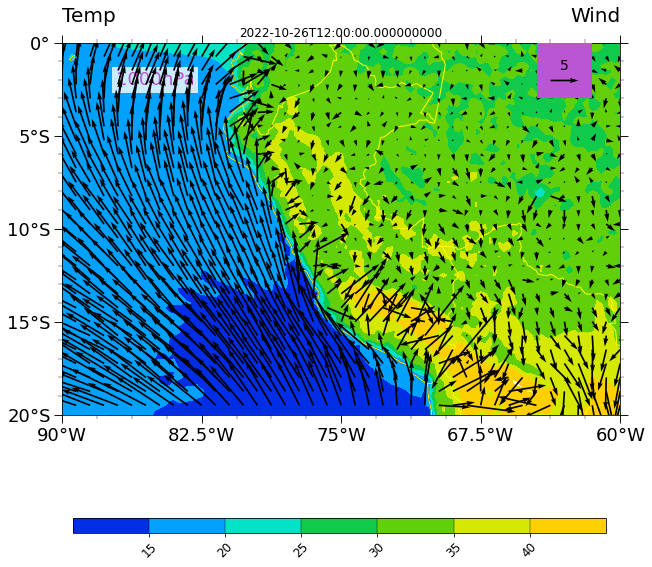

In [14]:


# definiendo las dimensiones y proyección de la nueva figura
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=projection)

ax.set_extent([lon.min(), lon.max(), lat.min(), lat.max()], crs=projection)
ax.coastlines('50m', linewidth=0.8)
ax.add_feature(cf.BORDERS, edgecolor="yellow")
ax.add_feature(cf.COASTLINE, edgecolor="yellow")

# gráfico de contorno relleno de la temperatura
cf = ax.contourf(lon, lat, T, levels=clevs, cmap=newcmp, zorder=1)

# colocando la barra de colores en modo horizontal
cax = plt.axes((0.14, 0.08, 0.74, 0.02))
cbar = plt.colorbar(cf,
                    ax=ax,
                    cax=cax,
                    ticks=clevs[1:-1],
                    drawedges=True,
                    orientation='horizontal')
cbar.ax.tick_params(labelsize=12, rotation=45)


# Definiendo las características de las flechas
Q = ax.quiver(lon[::3,::3],
              lat[::3,::3],
              U[::3,::3],
              V[::3,::3],
              color='black',
              width=.003,
              scale=100.,
              headwidth=3.,
              zorder=4)

# Dibujo del cuadro del vector de velocidad de referencia
rect = plt.Rectangle((-64.5, -3),
                     3,
                     3,
                     facecolor='mediumorchid',
                     edgecolor=None,
                     zorder=4)
ax.add_patch(rect)
ax.quiverkey(Q,
             0.9,
             0.9,
             5,
             '5',
             labelpos='N',
             color='black',
             coordinates='axes',
             fontproperties={'size': 14},
             labelsep=0.1)

# Cuadro de la presión de referencia
props = dict(facecolor='white', edgecolor='none', alpha=0.8)
ax.text(lon.min()+5,
        lat.max()-2,
        '1000hPa',
        transform=projection,
        fontsize=18,
        ha='center',
        va='center',
        color='mediumorchid',
        bbox=props)

# definimos las caracteristicas de los "ticks"
gv.set_axes_limits_and_ticks(ax,
                             xticks=np.linspace(lon.min(), lon.max(), 5),
                             yticks=np.linspace(lat.min(), lat.max(), 5))

# Adicion de las latitudes y longitudes correspondientes
gv.add_lat_lon_ticklabels(ax)

# configuración de los "ticks" mayores y menores
gv.add_major_minor_ticks(ax,
                         x_minor_per_major=4,
                         y_minor_per_major=5,
                         labelsize=18)

# Colocando titulos a conveniencia
gv.set_titles_and_labels(ax,
                         lefttitle="Temp",
                         lefttitlefontsize=20,
                         righttitle="Wind",
                         righttitlefontsize=20)

ax.set_title(f'{data_2.reftime.data[0]}')

# mostrar el gráfico final
plt.show()

Podemos verificar estos comportamiento en algunas [web](https://earth.nullschool.net/#current/wind/surface/level/orthographic=-73.19,-9.14,2080)

In [15]:
list(data_2)

['Temperature_isobaric',
 'Relative_humidity_isobaric',
 'u-component_of_wind_isobaric',
 'v-component_of_wind_isobaric',
 'LatLon_721X1440-0p13S-180p00E']

In [16]:
data_2.reftime.data

array(['2022-10-26T12:00:00.000000000'], dtype='datetime64[ns]')

In [17]:
lon.max()

-60.0

In [18]:
lat.min()

-20.0

In [19]:
T.min()

13.239868

In [20]:
U.max()

12.169381

In [21]:
V.max()

11.850533

## Retornar al [indice](./../indice.md)